In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [3]:
from pathlib import Path
import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_curve
import matplotlib.pyplot as plt

## data loading

### abundance + label

In [4]:
data_dir_path = Path("/home/labs/amit/noamsh/data/CAR_T")
cell_abundance_dataset_path  = Path(data_dir_path, "cell_type_abundance_by_sample_group_normalized.csv")
cell_abundance_dataset = pd.read_csv(cell_abundance_dataset_path)
cell_abundance_dataset = cell_abundance_dataset.set_index('sample_id')

y = cell_abundance_dataset['response_3m']
cell_abandace = cell_abundance_dataset.drop(columns=['response_3m', 'LDH_prior_tx'])
cell_abandace.index = cell_abandace.index.rename("patient")

print(cell_abandace.shape)
print(cell_abandace.columns)
cell_abandace.head()

(42, 18)
Index(['B', 'CD4.CM', 'CD4.EM', 'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive',
       'Cycling', 'MAIT', 'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono',
       'CD16 Mono', 'DCs', 'Inter Mono', 'pDC', 'B_category'],
      dtype='object')


,B,CD4.CM,CD4.EM,CD4.Naive,CD8.CM,CD8.EM,CD8.naive,Cycling,MAIT,NK.bright,NK.dim,Tregs,CD14 Mono,CD16 Mono,DCs,Inter Mono,pDC,B_category
patient,,,,,,,,,,,,,,,,,,
GIL_01,0.00000,0.03413,0.06143,0.19027,0.11604,0.35239,0.01109,0.06997,0.02133,0.00939,0.11348,0.02048,0.80223,0.04625,0.03668,0.10207,0.01276,B_unknown
GIL_02,0.00053,0.01163,0.03594,0.17336,0.10994,0.40275,0.03066,0.02854,0.00951,0.01374,0.16490,0.01903,0.75158,0.16737,0.01263,0.06632,0.00211,B_unknown
GIL_03,0.00201,0.04025,0.04441,0.13393,0.19570,0.39695,0.01457,0.02776,0.01319,0.00694,0.07703,0.04927,0.68304,0.14933,0.03468,0.13102,0.00193,B_unknown
GIL_04,0.01039,0.08419,0.05155,0.22852,0.06014,0.32646,0.01890,0.06014,0.00344,0.01890,0.07216,0.07560,0.49444,0.36111,0.02222,0.12222,0.00000,B_unknown
GIL_05,0.00358,0.01944,0.01080,0.10151,0.09287,0.25702,0.00432,0.02592,0.02808,0.08423,0.36933,0.00648,0.60175,0.21765,0.03032,0.14960,0.00067,B_unknown


In [26]:
# import numpy as np
# patient_shuffles = {}
# patients = np.array(cell_abandace.index)
# for i in range(10):
#     patient_shuffle = np.random.permutation(patients)
#     patient_shuffles[f"shuffle_{i+1}"]= patient_shuffle

# patient_shuffle_path  = Path(data_dir_path, "patients_shuffle.csv")
# pd.DataFrame(patient_shuffles).to_csv(patient_shuffle_path)

### long term labels

In [723]:
LTR_data_path = Path(data_dir_path, "cell_type_abundance_by_sample_group_normalized.LTR.csv")
LRT_data = pd.read_csv(LTR_data_path)
LRT_data = LRT_data[["sample_id", "response_3m", "LTR"]].rename(columns={"sample_id": "patient"}).set_index("patient")

In [755]:
y_ltr = LRT_data["LTR"]

In [724]:
pd.testing.assert_series_equal(LRT_data["response_3m"], y, check_names=False)

### baseline

In [725]:
baseline_data_path = Path(data_dir_path, "patients_baseline_predictions.csv")
baseline_data = pd.read_csv(baseline_data_path)
baseline_data = baseline_data.rename(columns={'Unnamed: 0': 'sample_id'})
baseline_data = baseline_data.set_index('sample_id')

baseline_data.index = baseline_data.index.rename("patient")

print(baseline_data.shape)
print(baseline_data.columns)
baseline_data.head()

(42, 7)
Index(['NR', 'R', 'predicted', 'TRUE', 'n_trials', 'predicted_proba',
       'prediction_scores'],
      dtype='object')


,NR,R,predicted,TRUE,n_trials,predicted_proba,prediction_scores
patient,,,,,,,
GIL_01,20,10,NR,NR,30,0.333333,-0.466667
GIL_02,17,11,NR,NR,28,0.392857,-0.323810
GIL_03,12,12,NR,NR,24,0.500000,-0.066667
GIL_04,3,17,R,NR,20,0.850000,0.773333
GIL_05,6,14,R,NR,20,0.700000,0.413333


In [726]:
pd.testing.assert_series_equal(baseline_data["TRUE"], y, check_names=False)

### patient metadata

In [727]:
metadata_path = Path(data_dir_path, "combined_df_plot.csv")
patient_metadata = pd.read_csv(metadata_path)

In [728]:
patient_metadata = patient_metadata[["sample_name", "time_difference_in_days", "Sex", "Age"]]
patient_metadata = patient_metadata.set_index("sample_name")
patient_metadata.index = patient_metadata.index.rename("patient")

In [729]:
print(patient_metadata.shape)
print(patient_metadata.columns)
patient_metadata.head()

(42, 3)
Index(['time_difference_in_days', 'Sex', 'Age'], dtype='object')


,time_difference_in_days,Sex,Age
patient,,,
Axi-01,23,M,73.17
Axi-02,27,F,47.44
Axi-03,114,M,71.62
Axi-04,27,F,70.16
Axi-05,32,M,72.82


### gene pathways

In [730]:
mye_pathways_path = Path(data_dir_path, "Myeloid_zscore_top10_padj_pathways.csv")
mye_pathways = pd.read_csv(mye_pathways_path)

print(mye_pathways.shape)
print(mye_pathways.columns)
mye_pathways.head()

(414, 7)
Index(['orig.ident', 'cell_type', 'cell_type_response', 'response_3m',
       'patient', 'zscore', 'cleaned_pathways'],
      dtype='object')


,orig.ident,cell_type,cell_type_response,response_3m,patient,zscore,cleaned_pathways
0,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-01,0.090858,HALLMARK_APICAL_JUNCTION
1,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-02,-0.046542,HALLMARK_APICAL_JUNCTION
2,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-03,-0.059306,HALLMARK_APICAL_JUNCTION
3,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-04,-0.013229,HALLMARK_APICAL_JUNCTION
4,NR,CD16 Mono,CD16 Mono_NR,NR,GIL-05,-0.010807,HALLMARK_APICAL_JUNCTION


In [731]:
mye_pathways['cleaned_pathways-cell_type'] = mye_pathways['cleaned_pathways'] + "-" + mye_pathways['cell_type'] 
mye_pathways_zscores = mye_pathways[['patient', 'zscore', 'cleaned_pathways-cell_type']].groupby(['patient', 'cleaned_pathways-cell_type'])["zscore"].sum().unstack(level=-1)
print(mye_pathways_zscores.shape)
print(mye_pathways_zscores.columns)
mye_pathways_zscores.head()
# mye_pathways_zscores

(42, 10)
Index(['HALLMARK_APICAL_JUNCTION-CD16 Mono', 'HALLMARK_APOPTOSIS-CD16 Mono',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-DCs', 'HALLMARK_P53_PATHWAY-DCs',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs'],
      dtype='object', name='cleaned_pathways-cell_type')


cleaned_pathways-cell_type,HALLMARK_APICAL_JUNCTION-CD16 Mono,HALLMARK_APOPTOSIS-CD16 Mono,HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono,HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono,HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono,HALLMARK_INFLAMMATORY_RESPONSE-DCs,HALLMARK_P53_PATHWAY-DCs,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono,HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs
patient,,,,,,,,,,
GIL-01,0.090858,0.142722,0.103711,-0.026402,0.125739,-0.079013,0.040826,-0.001839,0.035825,-0.061448
GIL-02,-0.046542,0.016285,0.003678,-0.054138,0.034415,-0.163298,0.056375,-0.014066,0.009606,-0.120022
GIL-03,-0.059306,0.036100,-0.014916,-0.126769,-0.016796,-0.179905,0.005903,-0.068230,-0.001888,-0.073733
GIL-04,-0.013229,0.042234,0.017455,0.044129,0.053433,0.152858,0.241357,0.059288,0.025582,0.225406
GIL-05,-0.010807,0.004165,-0.009597,-0.072766,0.008753,-0.049080,0.004847,-0.043784,-0.046632,-0.002140


### merge data

In [732]:
patient_col = "patient"

cell_abandace.index = cell_abandace.index.astype("string").str.replace("-","_")
mye_pathways_zscores.index = mye_pathways_zscores.index.astype("string").str.replace("-","_")
patient_metadata.index = patient_metadata.index.astype("string").str.replace("-","_")

In [733]:
all_X = cell_abandace.reset_index().merge(mye_pathways_zscores.reset_index(), how="inner", on=patient_col)
all_feats_names = {
    "mye_pathways": list(mye_pathways_zscores.columns),
    "abundance": list(cell_abandace.columns),
}

In [734]:
# all_X.merge(patient_metadata.reset_index(), on=patient_col, how="inner")
# patient_metadata.reset_index()
# all_X

In [735]:
all_X = all_X.set_index(patient_col)
print(all_X.shape, y.shape)
print(all_X.columns)

(41, 28) (42,)
Index(['B', 'CD4.CM', 'CD4.EM', 'CD4.Naive', 'CD8.CM', 'CD8.EM', 'CD8.naive',
       'Cycling', 'MAIT', 'NK.bright', 'NK.dim', 'Tregs', 'CD14 Mono',
       'CD16 Mono', 'DCs', 'Inter Mono', 'pDC', 'B_category',
       'HALLMARK_APICAL_JUNCTION-CD16 Mono', 'HALLMARK_APOPTOSIS-CD16 Mono',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD14 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-CD16 Mono',
       'HALLMARK_INFLAMMATORY_RESPONSE-DCs', 'HALLMARK_P53_PATHWAY-DCs',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD14 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-CD16 Mono',
       'HALLMARK_TNFA_SIGNALING_VIA_NFKB-DCs'],
      dtype='object')


In [736]:
class_map = {"R":1, "NR":0}
y = y.map(class_map)

In [757]:
y = y.loc[all_X.index]
y_ltr = y_ltr.loc[all_X.index]

## EDA

In [738]:
y.value_counts()

response_3m
1    28
0    13
Name: count, dtype: int64

## feature_selection

In [739]:
featurs =   all_feats_names["abundance"] + all_feats_names["mye_pathways"]
# featurs =  all_feats_names["mye_pathways"]
# featurs =   all_feats_names["abundance"]
X = all_X[featurs]

In [740]:
X = X.dropna(axis=1)

In [741]:
B_cat_map = {'B_unknown': -1, 'B_tumor': 0, 'B_healthy': 1}
if 'B_category' in featurs:
    X['B_category'] = X['B_category'].replace(B_cat_map)
    # print(X['B_category'].value_counts())

In [742]:
print(X.shape)
# X.head()

(41, 25)


## training

In [743]:
from sklearn.model_selection import train_test_split
from clinical_predictions.optuna_optimization import get_best_model_with_optuna

In [744]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# y_train.value_counts(), y_test.value_counts()

In [745]:
best_model, best_trail = get_best_model_with_optuna(X_train, y_train, precision_alpha = 0.5, n_trials=50)

[I 2024-04-04 11:26:34,925] A new study created in memory with name: no-name-5ee701b6-9003-428a-be6f-2012d6c2ba85
[I 2024-04-04 11:26:35,214] Trial 0 finished with value: 1.3040321368446368 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3, 'rf_n_estimators': 31}. Best is trial 0 with value: 1.3040321368446368.
[I 2024-04-04 11:26:35,340] Trial 1 finished with value: 1.1699006433381434 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2, 'rf_n_estimators': 8}. Best is trial 0 with value: 1.3040321368446368.
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

In [746]:
best_trail

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1.3040321368446368], datetime_start=datetime.datetime(2024, 4, 4, 11, 26, 34, 925535), datetime_complete=datetime.datetime(2024, 4, 4, 11, 26, 35, 214527), params={'classifier': 'RandomForest', 'rf_max_depth': 3, 'rf_n_estimators': 31}, user_attrs={'best_booster': RandomForestClassifier(max_depth=3, n_estimators=31)}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest', 'LogisticRegression')), 'rf_max_depth': IntDistribution(high=3, log=True, low=2, step=1), 'rf_n_estimators': IntDistribution(high=32, log=True, low=2, step=1)}, trial_id=0, value=None)

## evaluation

In [747]:
def plot_ROC_PRauc_CM_stem(y_true, y_pred, y_proba, pos_label):
    
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_label)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    roc_display.plot(ax=ax1, color="red")
    pr_display.plot(ax=ax2)
    cm_display.plot(ax=ax3)
    plot_stemplot(y_true, y_proba, ax=ax4)
    
    plt.show()

def plot_stemplot(y_true, y_proba, ax=None):
    y_df = pd.DataFrame(y_true)
    y_df["score"] = y_proba
    y_df = y_df.sort_values(by="score", ascending=False)
    y_df = y_df.reset_index().reset_index()

    y_df_response = y_df[y_df[y_true.name]==1]
    y_df_non_response = y_df[y_df[y_true.name]==0]

    if ax is None:
        (markers1, stemlines1, baseline1) = plt.stem(y_df_response['index'], y_df_response["score"], bottom=0.5)    
        (markers2, stemlines2, baseline2) = plt.stem(y_df_non_response['index'], y_df_non_response["score"], bottom=0.5)
        plt.setp(markers1, marker='o', markersize=3,markeredgecolor="red",  markeredgewidth=2)
        plt.setp(markers2, marker='o', markersize=3,markeredgecolor="blue",  markeredgewidth=2)
        plt.setp(stemlines1, linestyle="-", color="olive", linewidth=2 )
        plt.ylabel('Prediction scores')
    else:
        (markers1, stemlines1, baseline1) = ax.stem(y_df_response['index'], y_df_response["score"], bottom=0.5)    
        (markers2, stemlines2, baseline2) = ax.stem(y_df_non_response['index'], y_df_non_response["score"], bottom=0.5)
        plt.setp(markers1, marker='o', markersize=3,markeredgecolor="red",  markeredgewidth=2)
        plt.setp(markers2, marker='o', markersize=3,markeredgecolor="blue",  markeredgewidth=2)
        plt.setp(stemlines1, linestyle="-", color="olive", linewidth=2 )
        plt.ylabel('Prediction scores')

In [748]:
best_model

RandomForestClassifier(max_depth=3, n_estimators=31)

In [749]:
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:,1]
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


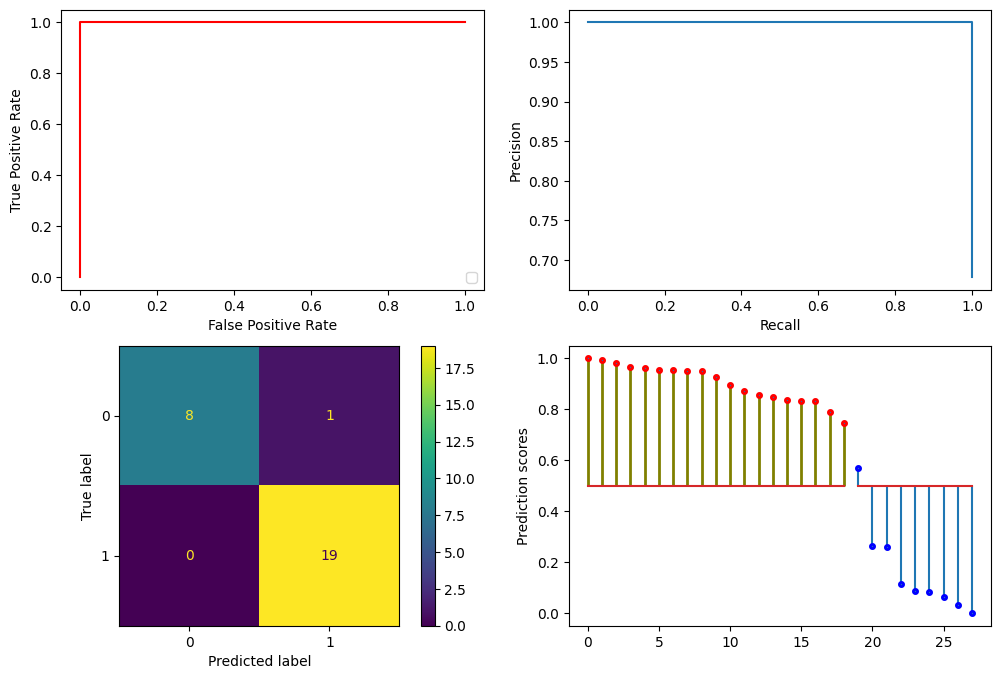

In [750]:
plot_ROC_PRauc_CM_stem(y_train, y_train_pred, y_train_proba, pos_label=best_model.classes_[1])

## explainability and error analisys

In [751]:
import shap

def print_shap_plots(model, X):
    try: # tree
        explainer = shap.TreeExplainer(model)
        # shap_values = explainer(X)
        # shap.plots.beeswarm(explanation)
        # shap.plots.bar(explanation)
    except:
        explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    if len(shap_values.shape) >2:
        shap_values = shap_values[:,:,1]
    shap.plots.beeswarm(shap_values)
    shap.plots.bar(shap_values, max_display=8)
    return shap_values


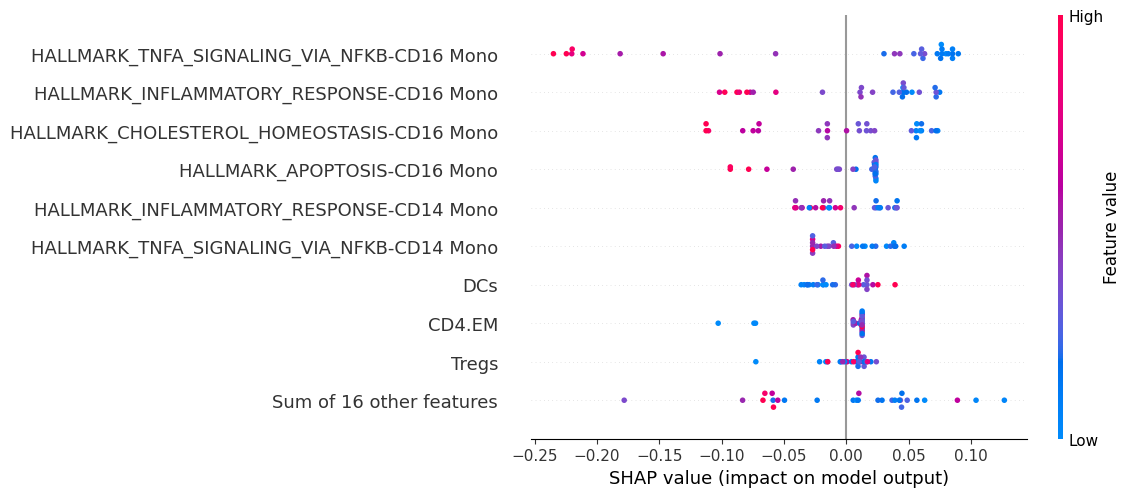

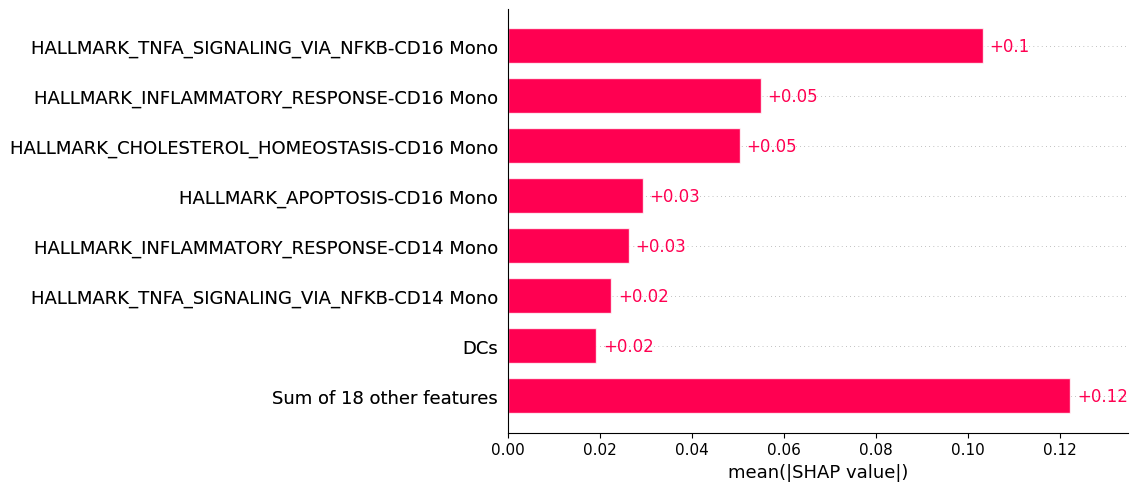

In [752]:
_ = print_shap_plots(best_model, X_train)

## test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


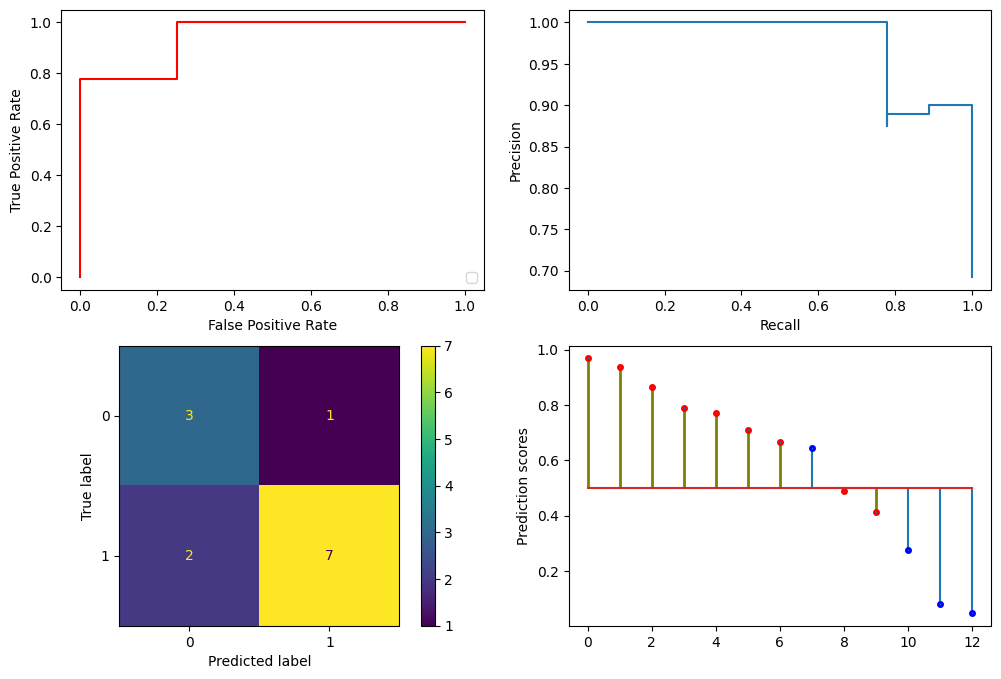

In [753]:
y_test_proba = best_model.predict_proba(X_test)[:,1]

plot_ROC_PRauc_CM_stem(y_test, y_test_pred, y_test_proba, pos_label=best_model.classes_[1])
